# 1. Setup and intial comments
The purpose of this notebook is to run inference on already trained and saved models, as well as visualizing the results of this. The notebook contains of three sections consisting of:
1.   Loading data, models, libraries and functions.
2.   Running inference on the test set and presenting the results hereof.
3.   Insights of the train and validation process through plots of the development in objective losses. All training was performed through the `src/stargan/train.py` script in our GitHub repository on DTU's HPC servers, using different available GPUs. This notebook therfore doesn't contain the training script. 



**Remember to run the notebook using GPU!**

## 1.1 Load the data and the models
First off, we need to clone the different models that we created ourselves. They are available at HuggingFace. Please note that it will take up a lot of temporal space on your colab session. 

**Note that you can simply comment out the links you don't want to download along with their added dictionary element**

In [1]:
Models = {}
!sudo apt-get install git-lfs
!git lfs install

# Model using depthwise convolutions (140 epochs), 40 domains
!git clone https://huggingface.co/jonpodtu/StarganDW140 
Models['StarganPhoneDW'] = {'model': 'StarganDW140/epoch_00140.pth',
                            'config': 'StarganDW140/config_DW.yml'}

# Model using regular convolutions (140 epochs), 40 domains
!git clone https://huggingface.co/jonpodtu/Stargan140   # Model using full convolutions (100 epochs)
Models['StarganPhone'] = {'model': 'Stargan140/epoch_00140.pth',
                         'config': 'Stargan140/config.yml'}

# Model using depthwise convolutions (100 epochs), 40 domains, but were the the last 20 domain contains duplicate of sentences in the first 20 domain (but distorted)
# !git clone https://huggingface.co/jonpodtu/StarganPhoneHomeDW
# Models['StarganPhoneDWLeakage'] = {'model': 'StarganPhoneHomeDW/epoch_00100.pth',
#                                   'config': 'StarganPhoneHomeDW/config.yml'}
                                   
# Model using regular convolutions (100 epochs), 40 domains, but were the the last 20 domain contains duplicate of sentences in the first 20 domain (but distorted)
# !git clone https://huggingface.co/jonpodtu/StarganPhoneHome #
# Models['StarganPhoneLeakage'] = {'model': 'StarganPhoneHome/epoch_00100.pth',
#                                  'config': 'StarganPhoneHome/config.yml'}, 

Reading package lists... Done
Building dependency tree       
Reading state information... Done
git-lfs is already the newest version (2.3.4-1).
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'sudo apt autoremove' to remove it.
0 upgraded, 0 newly installed, 0 to remove and 20 not upgraded.
Error: Failed to call git rev-parse --git-dir --show-toplevel: "fatal: not a git repository (or any of the parent directories): .git\n"
Git LFS initialized.
Cloning into 'StarganDW140'...
remote: Enumerating objects: 9, done.
remote: Counting objects: 100% (9/9), done.
remote: Compressing objects: 100% (8/8), done.
remote: Total 9 (delta 1), reused 0 (delta 0), pack-reused 0
Unpacking objects: 100% (9/9), done.
Cloning into 'Stargan140'...
remote: Enumerating objects: 9, done.
remote: Counting objects: 100% (9/9), done.
remote: Compressing objects: 100% (8/8), done.
remote: Total 9 (delta 1), reused 0 (delta 0), pack-reused 0
Unpacking objects

# 1.2: (Optional) Download the original Stargan-V2-VC for comparison. 
Since it can be relevant to look what the model can accomplish without training on NarrowBand voice data, we download the original model thar the team behind the paper has provided.

In [2]:
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
# Authenticate and create the PyDrive client.
# This only needs to be done once per notebook.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)
file_id = '1nzTyyl-9A1Hmqya2Q_f2bpZkUoRjbZsY' # URL id. 
downloaded = drive.CreateFile({'id': file_id})
downloaded.GetContentFile('Models.zip')
!unzip Models.zip # Origial Stargan-V2-VC model (150 epochs)
Models['StarganOrg'] =  {'model': 'Models/epoch_00150.pth', 
                         'config': 'Models/config.yml'}

Archive:  Models.zip
   creating: Models/
  inflating: Models/config.yml       
  inflating: Models/epoch_00150.pth  


## 1.3 Load libraries
The below cells consists mainly of nessecary libraries and functions.

In [3]:
%%capture
!pip install munch
!pip install parallel_wavegan
!pip install pesq
!pip install seaborn==0.12.1
!git clone https://github.com/jonpodtu/EnhancingSpeech_02456

import sys
from google.colab import drive

# load packages
import yaml
from munch import Munch
import numpy as np
import torch
import torch.nn.functional as F
import torchaudio
import librosa
from parallel_wavegan.utils import load_model
import os
import time
import soundfile as sf
import random
from pesq import pesq
import cv2
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from ast import literal_eval
import seaborn as sns

# And our modified models 
# drive.mount('/content/drive/')
# path_to_project='/content/drive/MyDrive/Project'
path_to_project = 'EnhancingSpeech_02456'
sys.path.append(path_to_project)

# Stargan imports
# Source: http://speech.ee.ntu.edu.tw/~jjery2243542/resource/model/is18/en_speaker_used.txt
# Source: https://github.com/jjery2243542/voice_conversion
from src.stargan.Utils.JDC.model import JDCNet

In [28]:
# Function that translate a waveform into a mel spectrogram using same setting as in the paper
to_mel = torchaudio.transforms.MelSpectrogram(
    n_mels=80, n_fft=2048, win_length=1200, hop_length=300
)

def mse_mel(img1, img2):
    """
    A naive solution to compute MSE between misalligned mel spectrograms. 
    The spectrograms proced by the models are of 1 or 2 frames off the
    original. We solved this by a simple reflection padding, assuming that
    there are some correlation in the time dimension.
    """
    _, a, b = img1.shape
    _, x, y = img2.shape
    if b < y:
        img1 = np.pad(img1, [(0,0), (0,0), (0,y-b)], 'reflect')
    if y < b:
        img2 = np.pad(img2, [(0,0), (0,0), (0,b-y)], 'reflect')
    _, h, w = img1.shape
    diff = cv2.subtract(img1, img2)
    err = np.sum(diff**2)
    mse = err / (float(h*w))
    return mse

# Inspiration: https://pytorch.org/tutorials/beginner/audio_preprocessing_tutorial.html
def plot_spectrogram(
    spec, title=None, ylabel="Frequency bin", aspect="auto", xmax=None, to_db=False
):
    fig, axs = plt.subplots(1, 1, dpi = 600)
    axs.set_title(title or "Spectrogram [dB]")
    axs.set_ylabel(ylabel)
    axs.set_xlabel("Frame")
    if to_db:
        spec = librosa.power_to_db(spec)
    im = axs.imshow(spec, origin="lower", aspect=aspect, cmap='viridis')
    if xmax:
        axs.set_xlim((0, xmax))
    fig.colorbar(im, ax=axs)
    axs.grid(False)
    plt.show(block=False)

# The below three functions;
    # preprocess
    # build_model
    # compute_style
# are from the source: https://github.com/yl4579/StarGANv2-VC/blob/main/Demo/inference.ipynb (Visited 24-12-2022)
# NB: there are slight modifications
def preprocess(wave):
    mean, std = -4, 4
    wave_tensor = torch.from_numpy(wave).float()
    mel_tensor = to_mel(wave_tensor)
    mel_tensor = (torch.log(1e-5 + mel_tensor.unsqueeze(0)) - mean) / std
    return mel_tensor

def build_model(model_params={}):
    args = Munch(model_params)
    generator = Generator(
        args.dim_in,
        args.style_dim,
        args.max_conv_dim,
        w_hpf=args.w_hpf,
        F0_channel=args.F0_channel,
    )
    mapping_network = MappingNetwork(
        args.latent_dim, args.style_dim, args.num_domains, hidden_dim=args.max_conv_dim
    )
    style_encoder = StyleEncoder(
        args.dim_in, args.style_dim, args.num_domains, args.max_conv_dim
    )

    nets_ema = Munch(
        generator=generator,
        mapping_network=mapping_network,
        style_encoder=style_encoder,
    )

    return nets_ema


def compute_style(speaker_dicts, starganv2):
    reference_embeddings = {}
    for key, (path, speaker) in speaker_dicts.items():
        # USING STYLE ENCODER
        wave, sr = librosa.load(path, sr=24000)
        audio, index = librosa.effects.trim(wave, top_db=30)
        if sr != 24000:
            wave = librosa.resample(wave, sr, 24000)
        mel_tensor = preprocess(wave).to("cuda")

        with torch.no_grad():
            label = torch.LongTensor([speaker])
            ref = starganv2.style_encoder(mel_tensor.unsqueeze(1), label)
        
        reference_embeddings[key] = (ref, label)

    return reference_embeddings

### 1.3.1 Load F0_model and vocoder

In [14]:
F0_model = JDCNet(num_class=1, seq_len=192)
params = torch.load(path_to_project + "/src/stargan/Utils/JDC/bst.t7")["net"]
F0_model.load_state_dict(params)
_ = F0_model.eval()
F0_model = F0_model.to("cuda")

# load vocoder
vocoder = (
    load_model(path_to_project + "/src/stargan/Vocoder/checkpoint-400000steps.pkl").to("cuda").eval()
)
vocoder.remove_weight_norm()
_ = vocoder.eval()

# 2. Inference and results
Below is the code for doing inference on our test set. Running this takes about 15 minutes on Google Colab unpaid GPU services. However, if you wish to just investigate the results, move on to section 2.2. 

Some parts of the code below is heavily inspired by https://github.com/yl4579/StarGANv2-VC/blob/main/Demo/inference.ipynb (Visited 24-12-2022). 

## 2.1 Running inference on the test set

In [15]:
data_folders = os.listdir(os.path.join(path_to_project, "Data/valid"))
data_dict = {}
for key in data_folders:
    speakers = os.listdir(os.path.join(*[path_to_project, "Data/valid", key]))
    speakers.sort()
    assert len(speakers) == 20, "Not the right amount of speakers. Please make sure you have the right path_to_project"
    data_dict[key] = speakers

In [16]:
# We are only interested in converting to clean speakers
speakers = data_dict['refs']

np.set_printoptions(threshold=sys.maxsize)
# Define the speaker dict
speaker_dicts = {}

# It consists of a reference (if used, else we use the mapping network) and a speaker
refs_folder = os.path.join(*[path_to_project, "Data/valid/refs"])
for s in speakers:
    ref = os.path.join(refs_folder, s)
    ref = random.choice(os.listdir(ref)) # For now we simply pick a random reference
    speaker_dicts[s] = (
       os.path.join(*[refs_folder, s, ref]), speakers.index(s),
    )

The next cell collects the MSE and PESQ for the phone data before inference is performed. This is the most naïve approach.

The following cell then does inference for each model. This can that a while.

In [9]:
# Save settings
save_folder = ['StarganPhone', 'StarganPhoneLeakage'] # Insert models if you wish to save the result of inference, else, leave empty
models_results = {}

pesq_results = {}
mse_results = {}

# Lets get the baseline (just phone speech) as reference
for speaker in data_dict['val']:
    val_path = os.path.join(*[path_to_project, "Data/valid/val", speaker])
    files = os.listdir(val_path)

    key = speaker.replace('_filter', '')
        
    target_path = os.path.join(*[path_to_project, "Data/valid/target", key])

    pesq_speaker = []
    mse_speaker = []

    for f in files:

        # Loading the file to run inference through  (Also acting as original referrence)
        wav_path = os.path.join(val_path, f)
        audio, source_sr = librosa.load(wav_path, sr=24000)
        audio = audio / np.max(np.abs(audio))
        audio.dtype = np.float32
        # Preprocess to Mel-spec
        source = preprocess(audio).to("cuda:0")

        # Target file 
        wav_path = os.path.join(target_path, f)
        y, target_source_sr = librosa.load(wav_path, sr=24000)
        y = y / np.max(np.abs(y))
        y.dtype = np.float32
        y_processed = preprocess(y)

        # MSE
        mse_speaker.append(mse_mel(y_processed.numpy(), source.to("cpu").numpy())) # Comparing full signal and phone. #TODO: Move this outside the loop. Only has to be done once
        
        # PESQ
        audio = librosa.resample(audio, orig_sr=24000, target_sr=16000)
        y = librosa.resample(y, orig_sr=24000, target_sr=16000)
        pesq_speaker.append(pesq(ref = y, deg = audio, fs=16000, mode='wb')) # Comparing full signal and phone. #TODO: Move this outside the loop. Only has to be done once

    # ADD RESULTS TO SOME KIND OF DATAFRAME
    pesq_results[key] = pesq_speaker
    mse_results[key] = mse_speaker
        
models_results['PhoneReference'] = {'PESQ': pesq_results,
                                    'MSE': mse_results}

In [17]:
for model in Models.keys():
    # Load the model
    with open(Models[model]['config']) as f:
        starganv2_config = yaml.safe_load(f)

    # The original model did not have an depthwise option
    if not 'depthwise' in starganv2_config:
        starganv2_config['depthwise'] = False
    if starganv2_config['depthwise']:
        from src.stargan.models_depthwise_convolutions import Generator, MappingNetwork, StyleEncoder
    else:
        from src.stargan.models import Generator, MappingNetwork, StyleEncoder

    starganv2 = build_model(model_params=starganv2_config["model_params"])
    params = torch.load(Models[model]['model'], map_location="cpu")
    params = params["model_ema"]
    _ = [starganv2[key].load_state_dict(params[key]) for key in starganv2]
    _ = [starganv2[key].eval() for key in starganv2]
    starganv2.style_encoder = starganv2.style_encoder.to("cuda")
    starganv2.mapping_network = starganv2.mapping_network.to("cuda")
    starganv2.generator = starganv2.generator.to("cuda")

    # Compute style encoder
    reference_embeddings = compute_style(speaker_dicts, starganv2)

    # Lets validate our speakers
    pesq_results = {}
    mse_results = {}

    for speaker in data_dict['val']:
        val_path = os.path.join(*[path_to_project, "Data/valid/val", speaker])
        files = os.listdir(val_path)
        key = speaker.replace('_filter', '')
        
        target_path = os.path.join(*[path_to_project, "Data/valid/target", key])

        pesq_speaker = []
        mse_speaker = []

        for f in files:
            # Loading the file to run inference through  (Also acting as original referrence)
            wav_path = os.path.join(val_path, f)
            audio, source_sr = librosa.load(wav_path, sr=24000)
            audio = audio / np.max(np.abs(audio))
            audio.dtype = np.float32
            # Preprocess to Mel-spec
            source = preprocess(audio).to("cuda:0")

            # Inference
            with torch.no_grad():
                f0_feat = F0_model.get_feature_GAN(source.unsqueeze(1))
                out = starganv2.generator(source.unsqueeze(1), reference_embeddings[key][0], F0=f0_feat)

                c = out.transpose(-1, -2).squeeze().to("cuda")
                y_out = vocoder.inference(c)
                y_out = y_out.view(-1).cpu()
            y_out_processed = preprocess(y_out.numpy())

            if save_folder and (model in ['StarganPhone', 'StarganPhoneLeakage']):
                save_folder = os.path.join(*[path_to_project, "Data/valid/inference", model, key])
                if not os.path.exists(save_folder):
                    os.makedirs(save_folder)
                    # Write out audio
                sf.write(
                    os.path.join(save_folder, "{}".format(f)),
                    y_out.numpy(),
                    samplerate=24000,
                )

            # Target file 
            wav_path = os.path.join(target_path, f)
            y, target_source_sr = librosa.load(wav_path, sr=24000)
            y = y / np.max(np.abs(y))
            y.dtype = np.float32
            y_processed = preprocess(y)

            # MSE
            mse_speaker.append(mse_mel(y_processed.numpy(), y_out_processed.numpy())) # Comparing full signal and stargan generated

            # PESQ NEED THE SAMPLING RATE TO BE 16000
            y_out = librosa.resample(y_out.numpy(), orig_sr=24000, target_sr=16000)
            y = librosa.resample(y, orig_sr=24000, target_sr=16000)
            pesq_speaker.append(pesq(ref = y, deg = y_out, fs=16000, mode='wb')) # Comparing full signal and stargan generated

        # ADD RESULTS TO SOME KIND OF DATAFRAME
        pesq_results[key] = pesq_speaker
        mse_results[key] = mse_speaker
            
    models_results[model] = {'PESQ': pesq_results,
                             'MSE': mse_results}

temp = pd.DataFrame.from_dict({(i,j): models_results[i][j] 
                           for i in models_results.keys() 
                           for j in models_results[i].keys()},
                       orient='index')
temp.to_csv(os.path.join(*[path_to_project, 'docs/results', "Results_all_v3.csv"]))

### 2.2 Handling the results
The first cell consists of some helper functions making the plots suitable for the report. The second cell does some simple reorganizing of the dataframe produced above. The third cell plots the results, and the last cell performs pairwise t-tests.

In [18]:
# Function "set_size" IS FROM https://jwalton.info/Embed-Publication-Matplotlib-Latex/
def set_size(width, fraction=1, subplots=(1, 1), height_ratio=1):
    """Set figure dimensions to avoid scaling in LaTeX.

    Parameters
    ----------
    width: float or string
            Document width in points, or string of predined document type
    fraction: float, optional
            Fraction of the width which you wish the figure to occupy
    subplots: array-like, optional
            The number of rows and columns of subplots.
    Returns
    -------
    fig_dim: tuple
            Dimensions of figure in inches
    """
    if width == "thesis":
        width_pt = 426.79135
    elif width == "beamer":
        width_pt = 307.28987
    elif width == "project":
        width_pt = 506.45905
    else:
        width_pt = width

    # Width of figure (in pts)
    fig_width_pt = width_pt * fraction
    # Convert from pt to inches
    inches_per_pt = 1 / 72.27

    # Golden ratio to set aesthetic figure height
    # https://disq.us/p/2940ij3
    golden_ratio = (5 ** 0.5 - 1) / 2

    # Figure width in inches
    fig_width_in = fig_width_pt * inches_per_pt
    # Figure height in inches
    fig_height_in = fig_width_in * golden_ratio * (subplots[0] / subplots[1])
    fig_height_in = fig_height_in * height_ratio

    return (fig_width_in, fig_height_in)


def set_style():
    sns.set_context("paper")
    sns.set(
        context="paper",
        style="whitegrid",
        font_scale=1,
        rc={
            "xtick.bottom": True,
            "ytick.left": True,
            "axes.edgecolor": ".15",
            "lines.solid_capstyle": "butt",
            "figure.dpi": 600,
            "savefig.dpi": 600,
            "axes.labelsize": 10,
            "font.size": 10,
            "legend.fontsize": 8,
            "xtick.labelsize": 8,
            "ytick.labelsize": 8,
        },
    )

In [19]:
df = pd.read_csv(os.path.join(path_to_project, "docs/results/Results_all_v3.csv"), index_col=[0, 1])
df = df.reindex(['StarganOrg','StarganPhone','StarganPhoneDW','PhoneReference',], level=0)
df = df.applymap(literal_eval).applymap(np.mean)
df = df.T.unstack().reset_index()
df.columns = ["Model", "Error", "Person", "Value"]

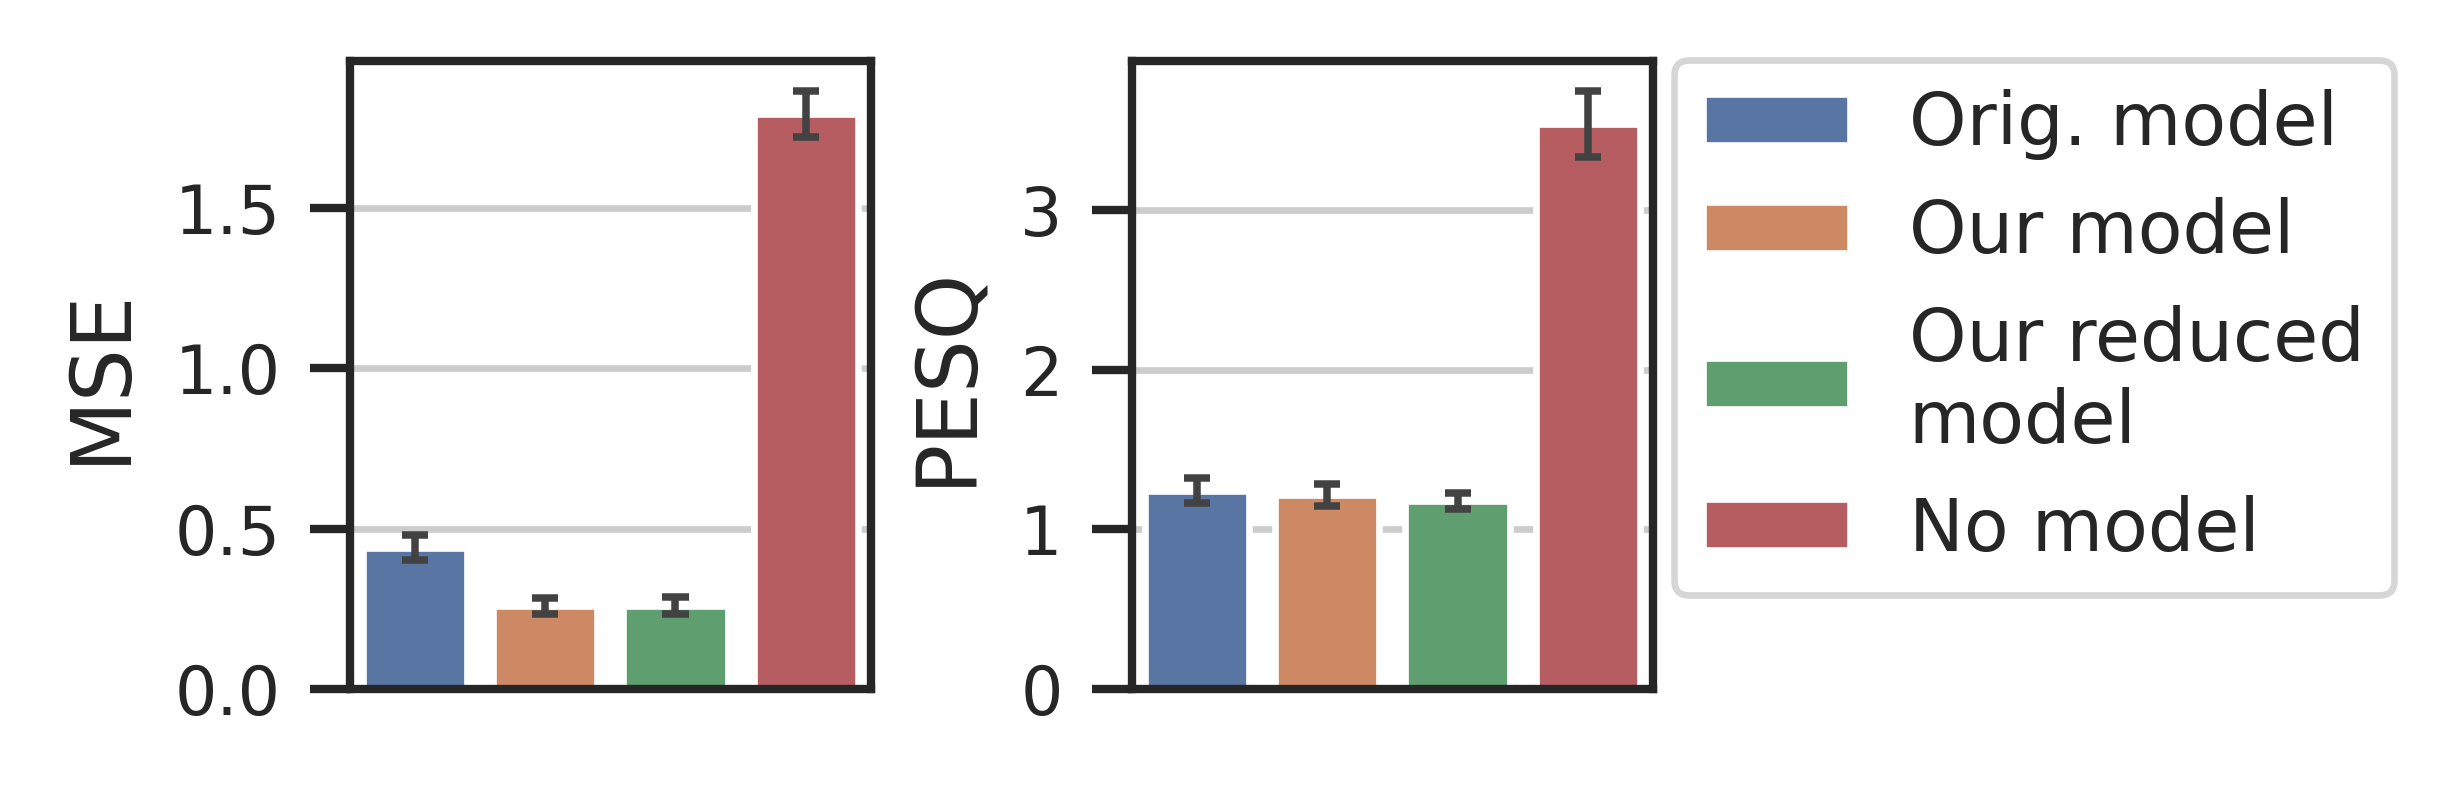

In [20]:
set_style()
f, axes = plt.subplots(1, 2, figsize=(set_size("project", fraction=0.4, height_ratio=0.8)))
sns.set_context("paper")
g1 = sns.barplot(data=df[df['Error'] == "MSE"], x="Model", y="Value", hue="Model", errorbar=('se', 2), dodge=False, capsize=0.2, errwidth=0.9, ax=axes[0])
g2 = sns.barplot(data=df[df['Error'] == "PESQ"], x="Model", y="Value", hue="Model", errorbar=('se', 2), dodge=False, capsize=0.2, errwidth=0.9, ax=axes[1])
handles, labels = g1.get_legend_handles_labels()
plt.legend(handles = handles, labels = ["Orig. model", "Our model", "Our reduced\nmodel", "No model"], ncol=1, bbox_to_anchor=(1.04, 0.15), loc="lower left", borderaxespad=0) 
g1.set(xticklabels=[],xlabel=None,ylabel="MSE")
g1.set_xticks([])
g1.legend([],[], frameon=False)
g2.set_xticks([])
g2.set(xticklabels=[],xlabel=None, ylabel="PESQ")
plt.subplots_adjust(wspace=0.5)
plt.savefig("errors.pdf", format="pdf", bbox_inches="tight")
plt.show()

In [21]:
from scipy.stats import ttest_ind
def get_ttest(err_type, mdl1, mdl2):
    df_slice_1 = df[(df.Error == err_type) & (df.Model == mdl1)]
    df_slice_2 = df[(df.Error == err_type) & (df.Model == mdl2)]
    test = ttest_ind(df_slice_1['Value'], df_slice_2['Value'])
    print("{} t-test betweenn {} and {}: {}".format(err_type, mdl1, mdl2, test))
    return None

for err_type in ["PESQ", "MSE"]:
    get_ttest(err_type, "StarganPhone", "StarganPhoneDW")
    get_ttest(err_type, "StarganPhone", "StarganOrg")
    get_ttest(err_type, "StarganPhoneDW", "StarganOrg")

PESQ t-test betweenn StarganPhone and StarganPhoneDW: Ttest_indResult(statistic=0.9490616817867844, pvalue=0.34858636109419694)
PESQ t-test betweenn StarganPhone and StarganOrg: Ttest_indResult(statistic=-0.5312234110189769, pvalue=0.5983556158777305)
PESQ t-test betweenn StarganPhoneDW and StarganOrg: Ttest_indResult(statistic=-1.448605832725583, pvalue=0.15564974341753196)
MSE t-test betweenn StarganPhone and StarganPhoneDW: Ttest_indResult(statistic=-0.04644701225125422, pvalue=0.9631972104715781)
MSE t-test betweenn StarganPhone and StarganOrg: Ttest_indResult(statistic=-7.974054440198997, pvalue=1.232356043576503e-09)
MSE t-test betweenn StarganPhoneDW and StarganOrg: Ttest_indResult(statistic=-7.833327421668236, pvalue=1.8886129181995677e-09)


Having performed pairwise t-test, we can conclude the following:
- Looking at PESQ, we cannot reject the null hypothesis between any of the first three models, which indicates that non of the results a significantly better than the others.
- Looking at MSE, we can reject the null hypothes between the original stargan model and our two models, thereby 

## 2.3 A few spectrogram exammples

In [22]:
speaker = data_dict['val'][3]
val_path = os.path.join(*[path_to_project, "Data/valid/val", speaker])
files = os.listdir(val_path)
key = speaker.replace('_filter', '')

idx = 0
val_path = os.path.join(val_path, files[idx])
target_path = os.path.join(*[path_to_project, "Data/valid/target", key, files[idx]])
inference_path = os.path.join(*[path_to_project, "Data/inference/StarganPhone", key, files[idx] + ".wav"])
reference_path = speaker_dicts[key][0]
paths = [("Test", val_path), ("Target", target_path), ("Inference", inference_path), ("Reference", reference_path)]

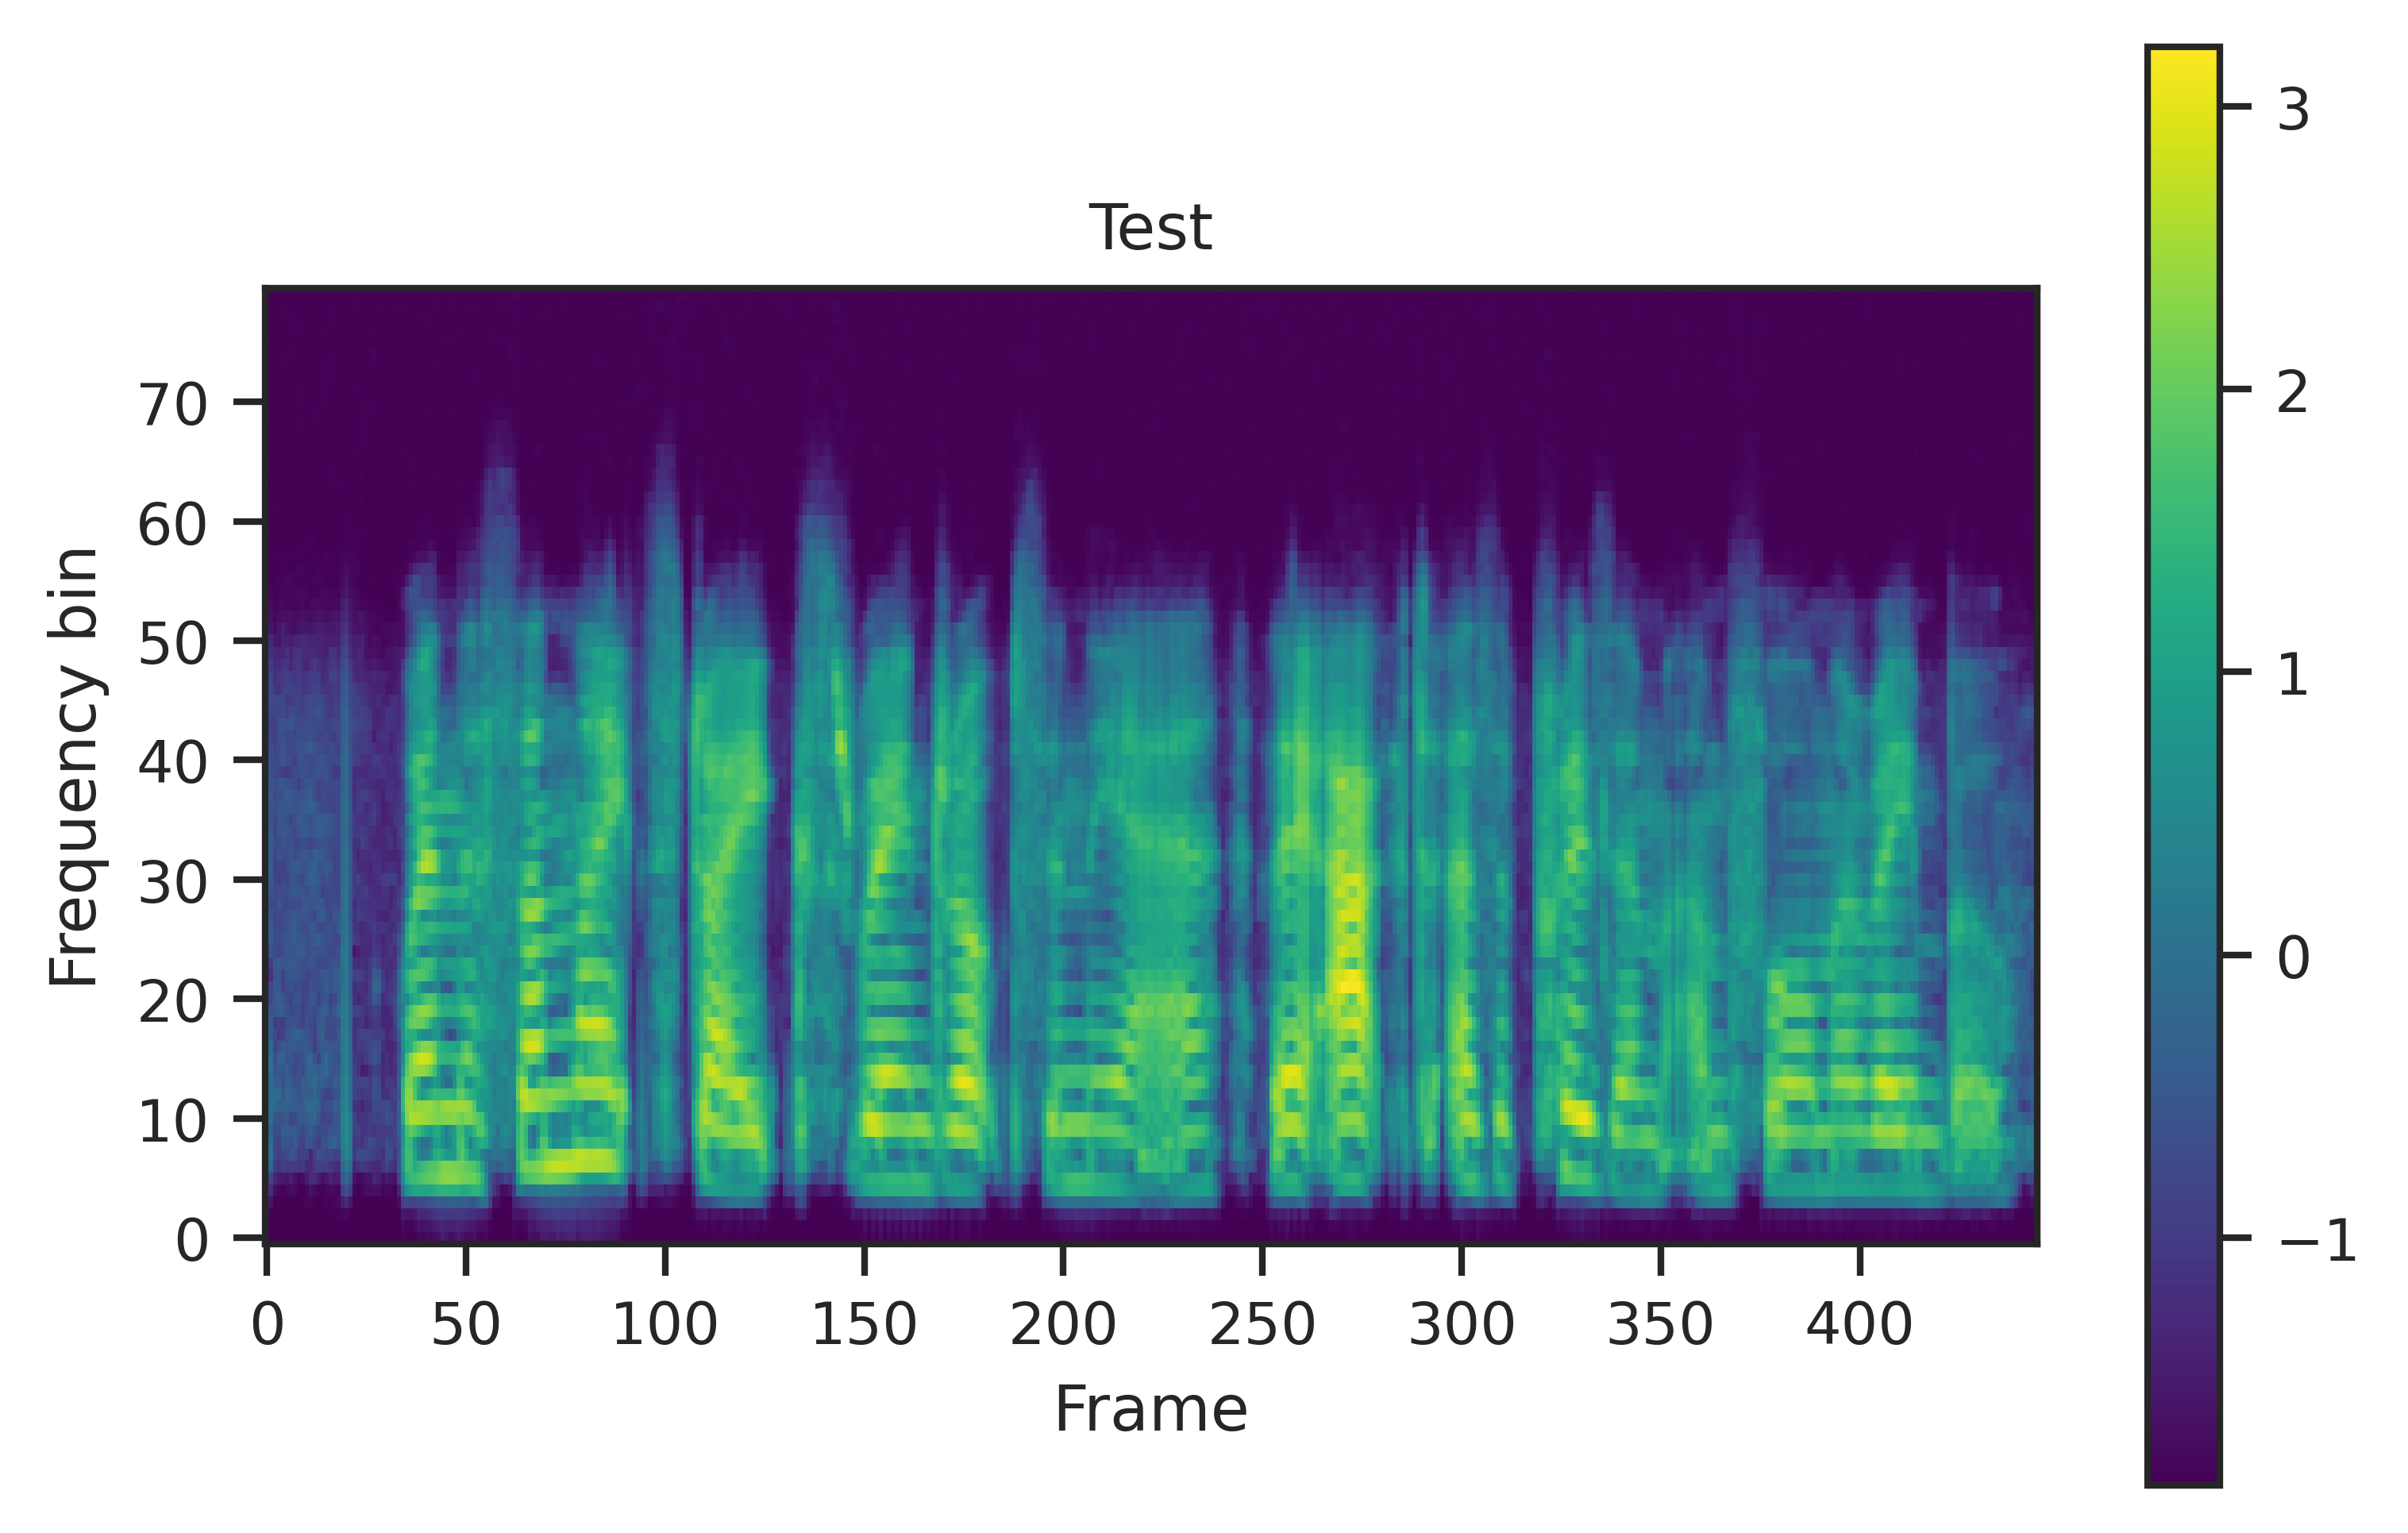

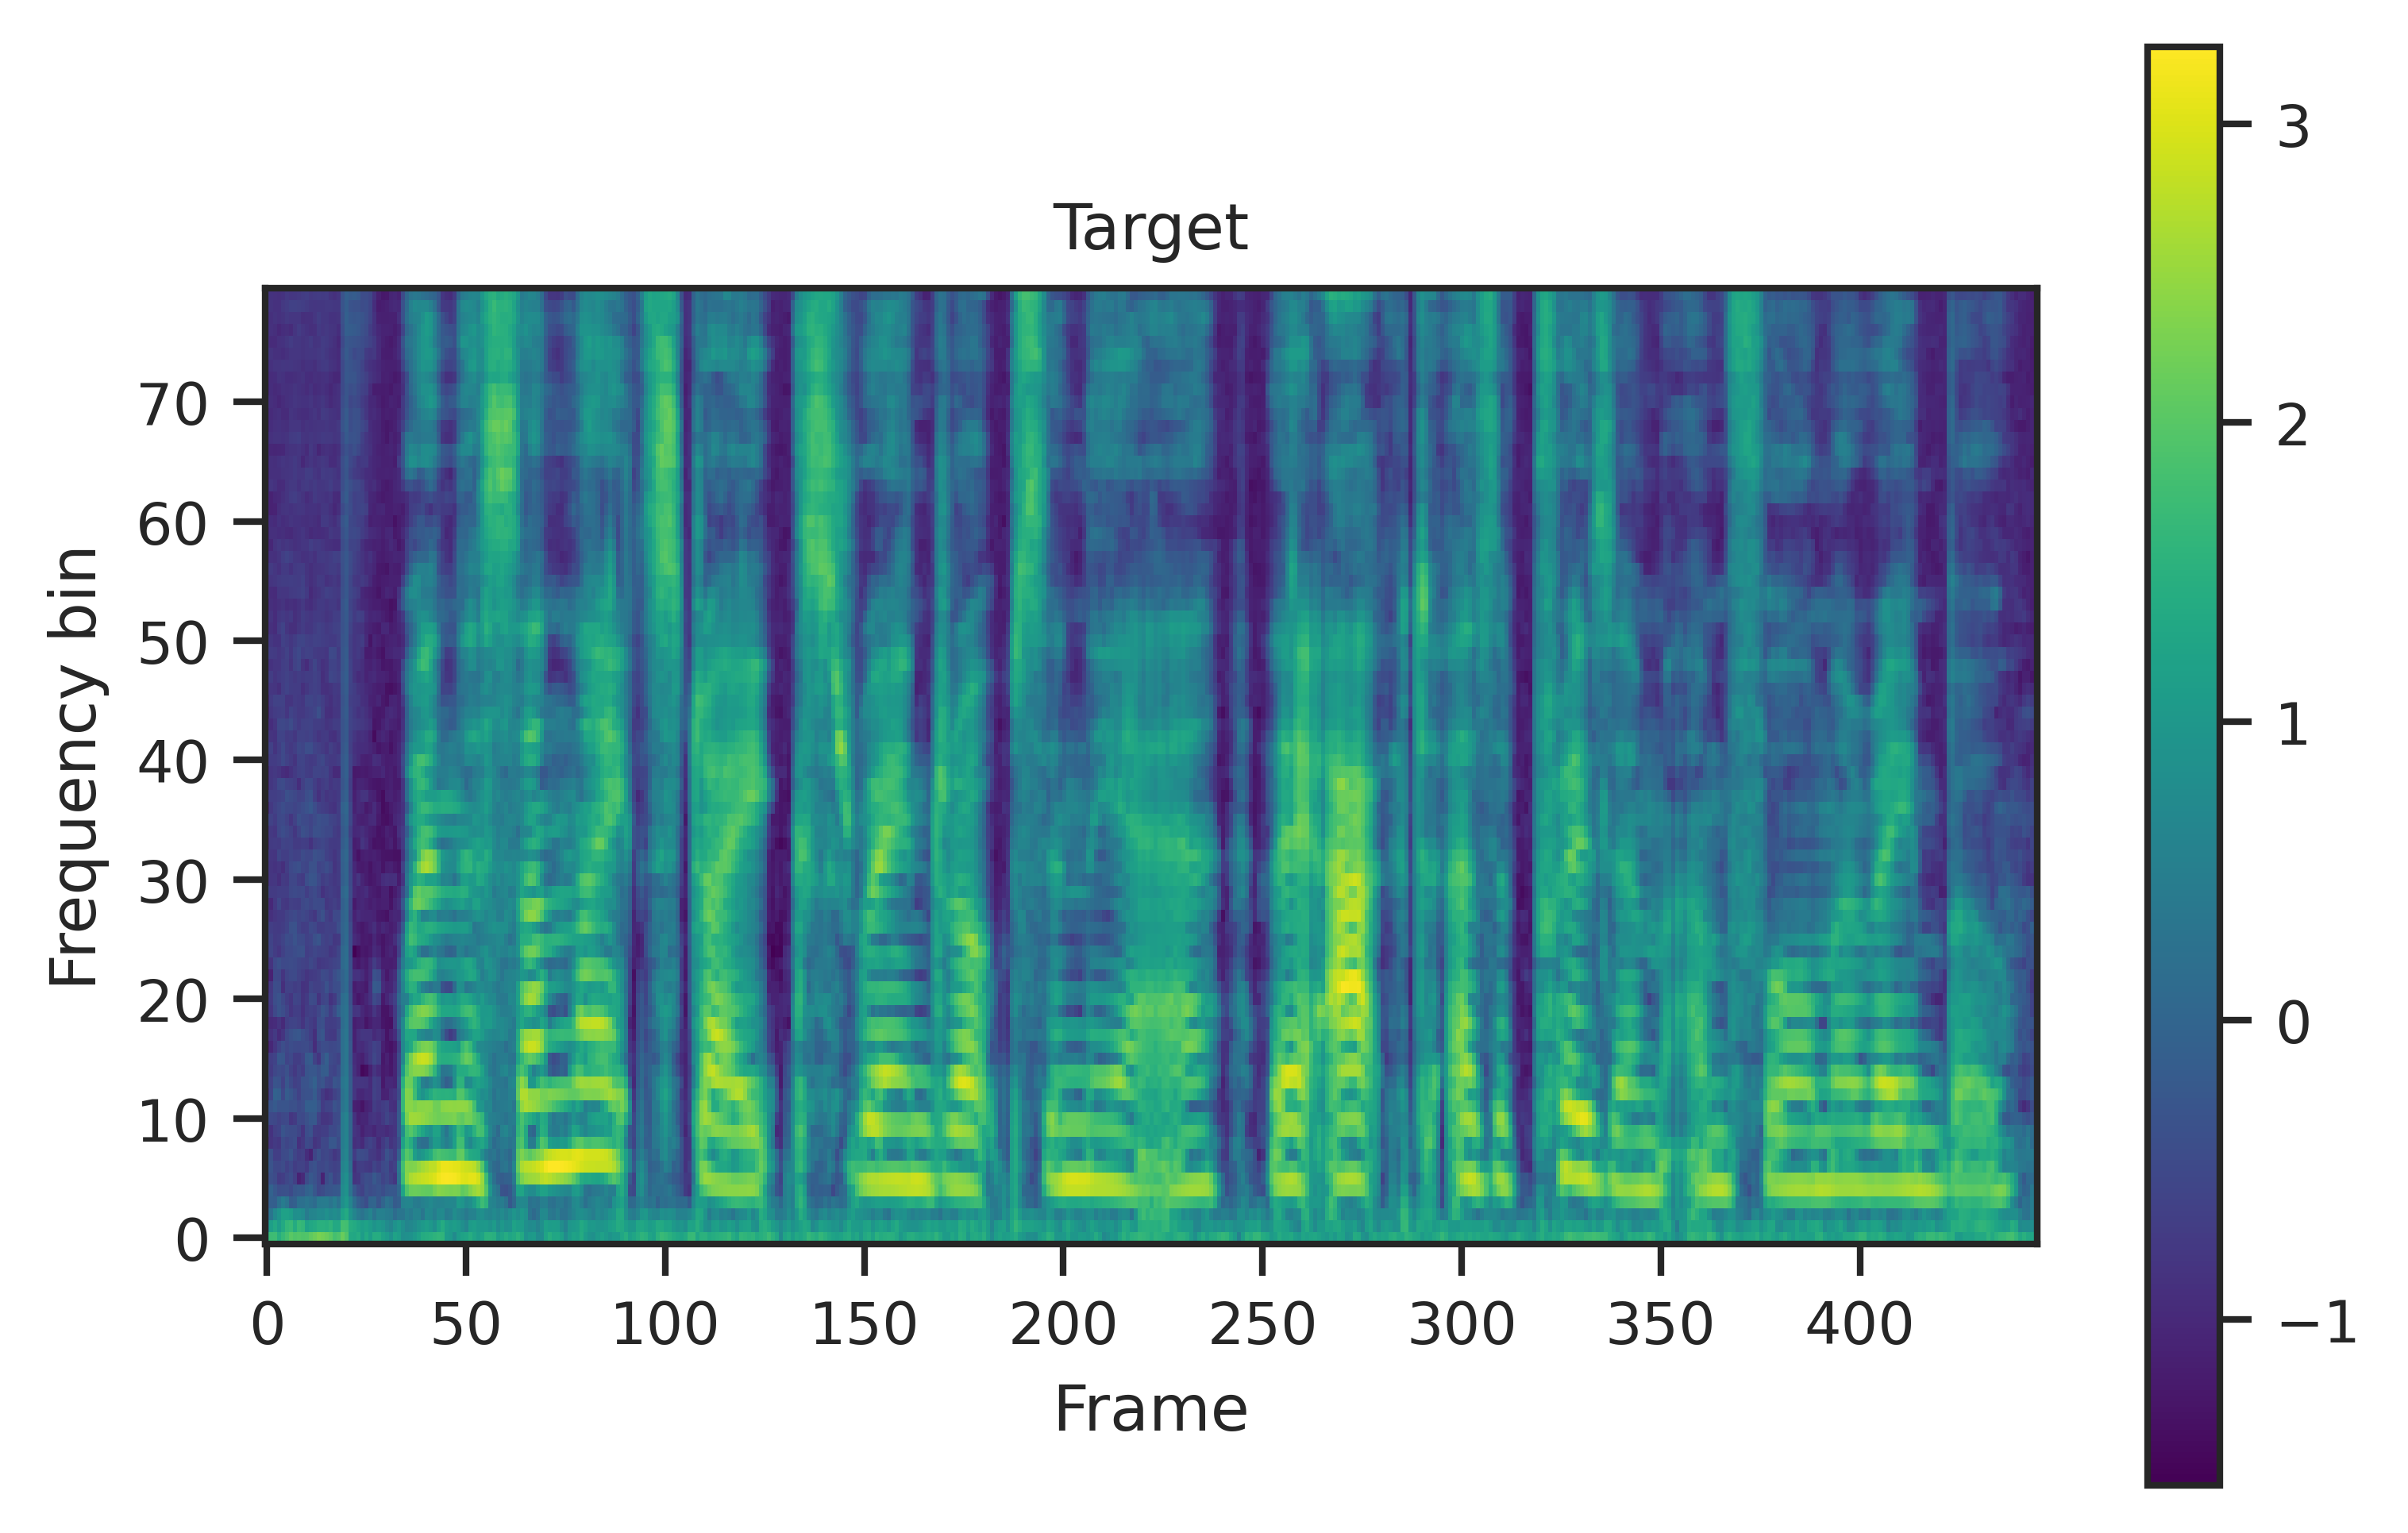

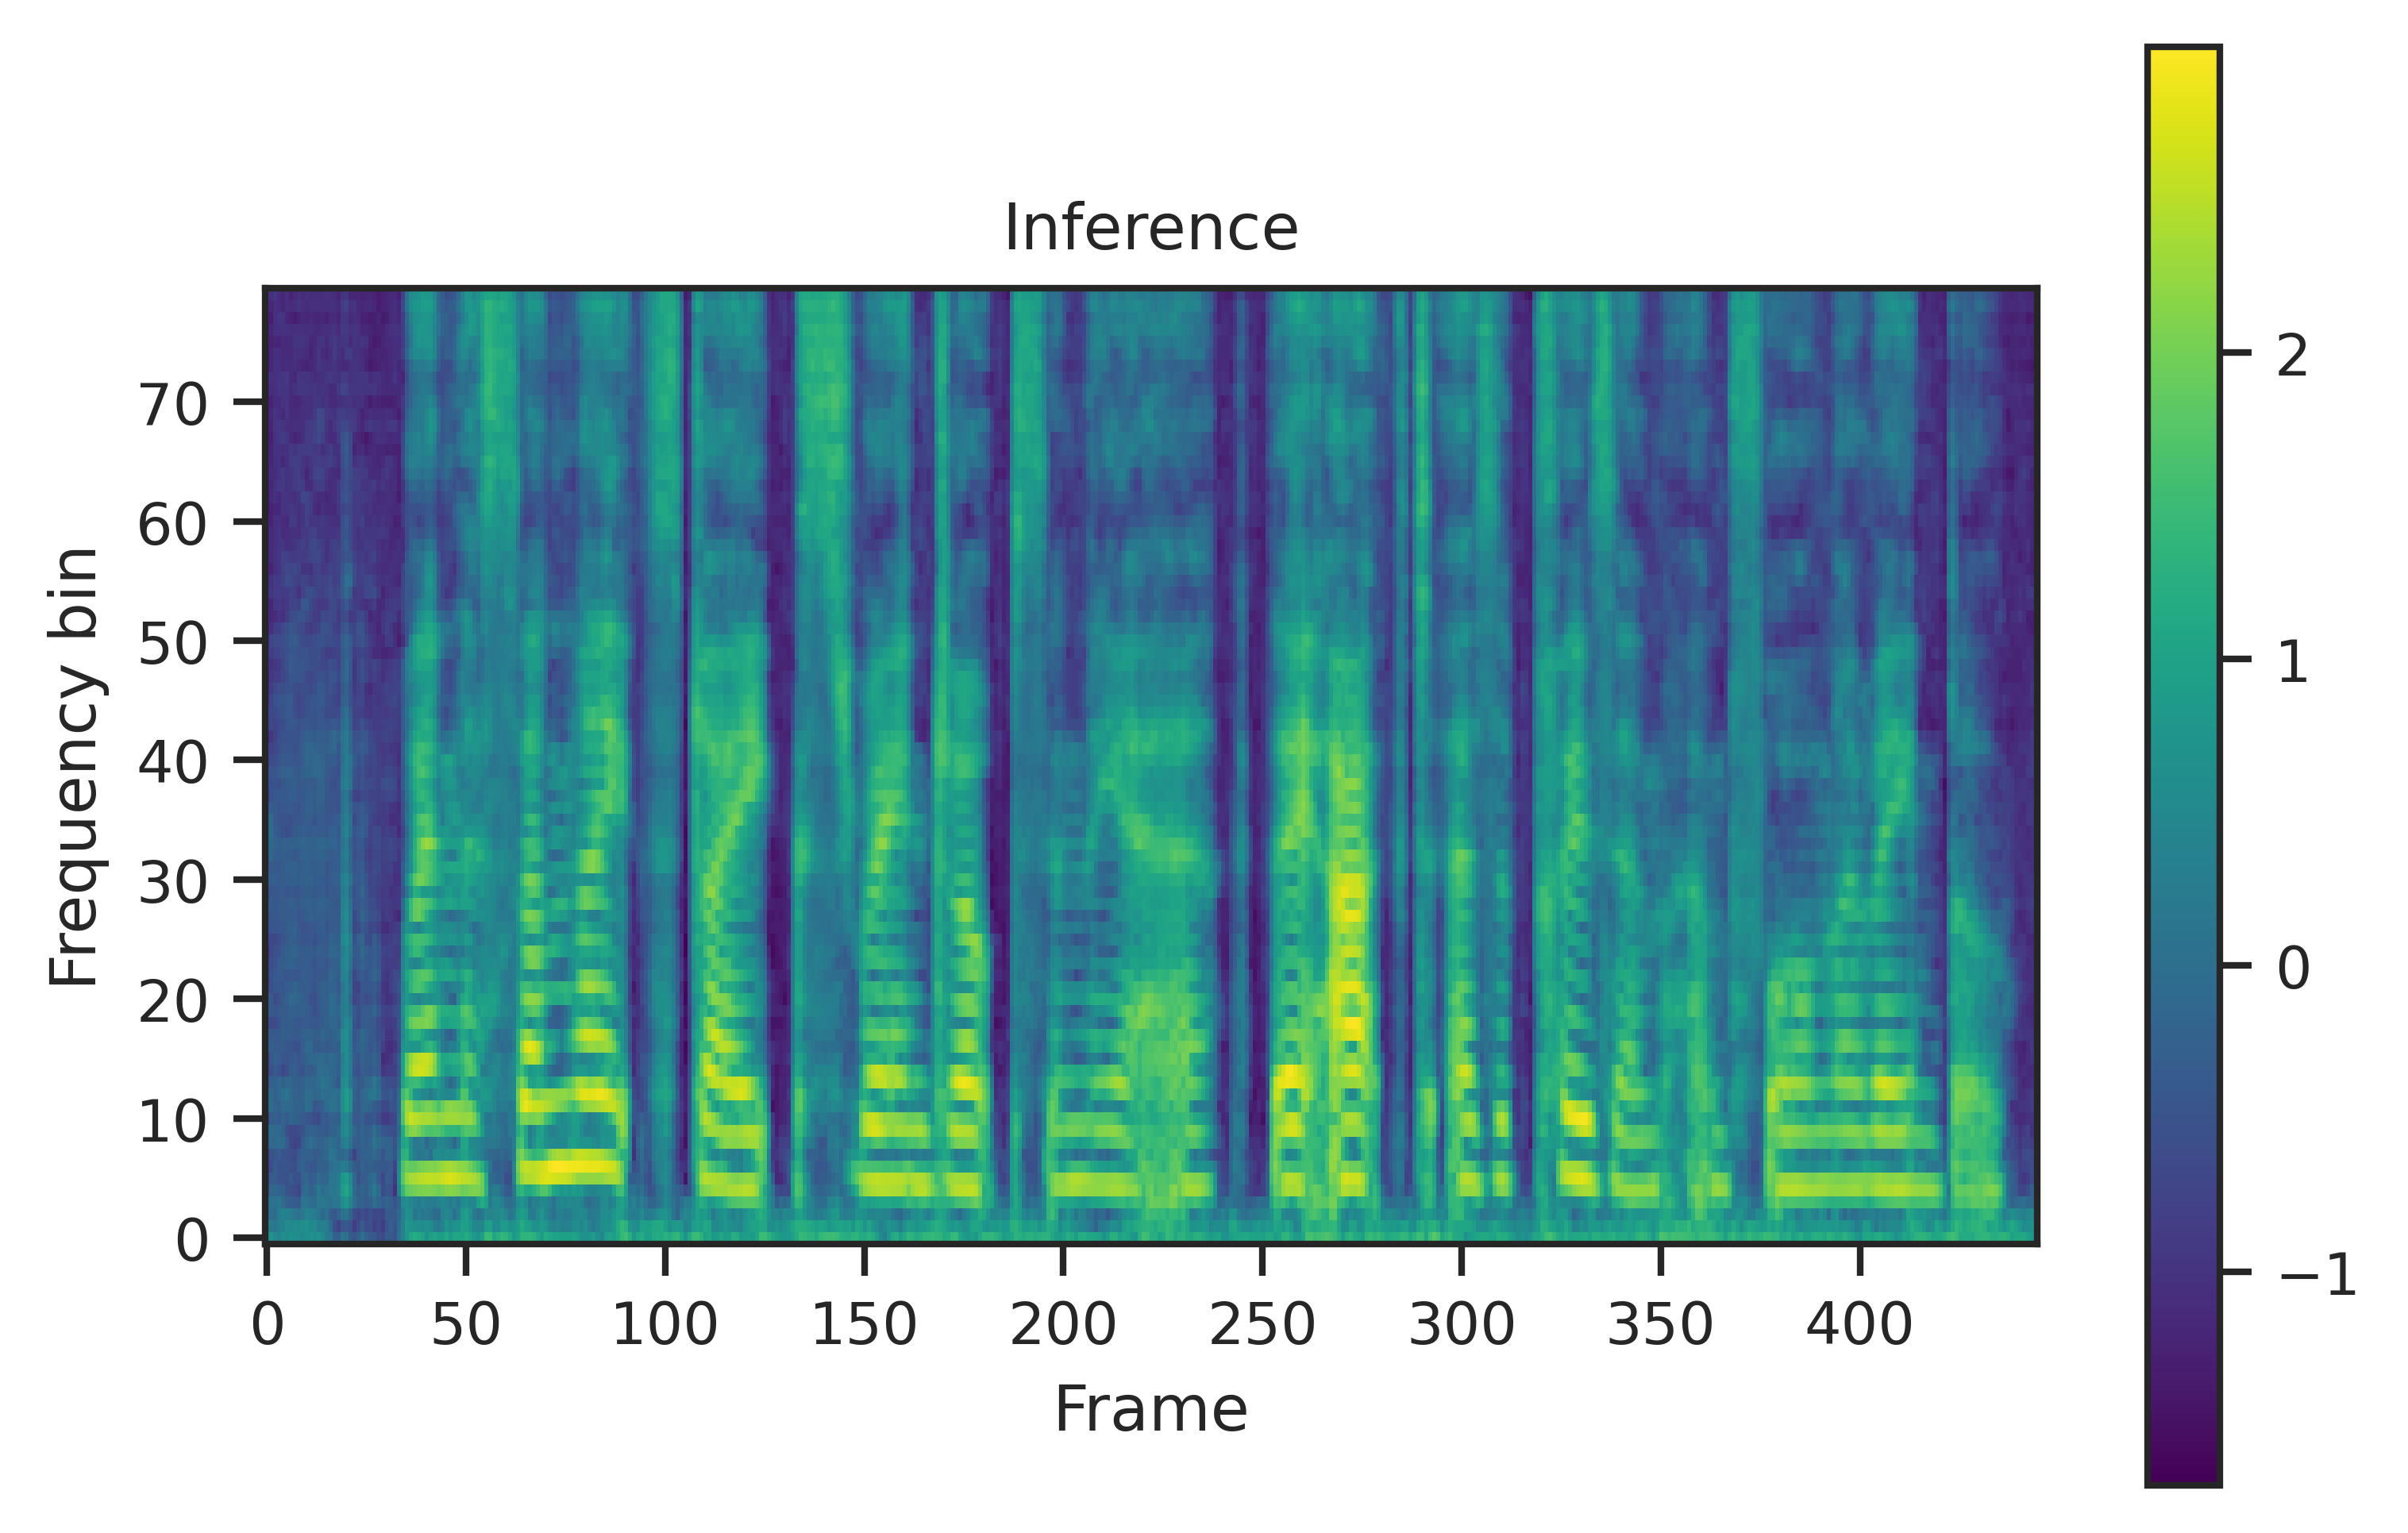

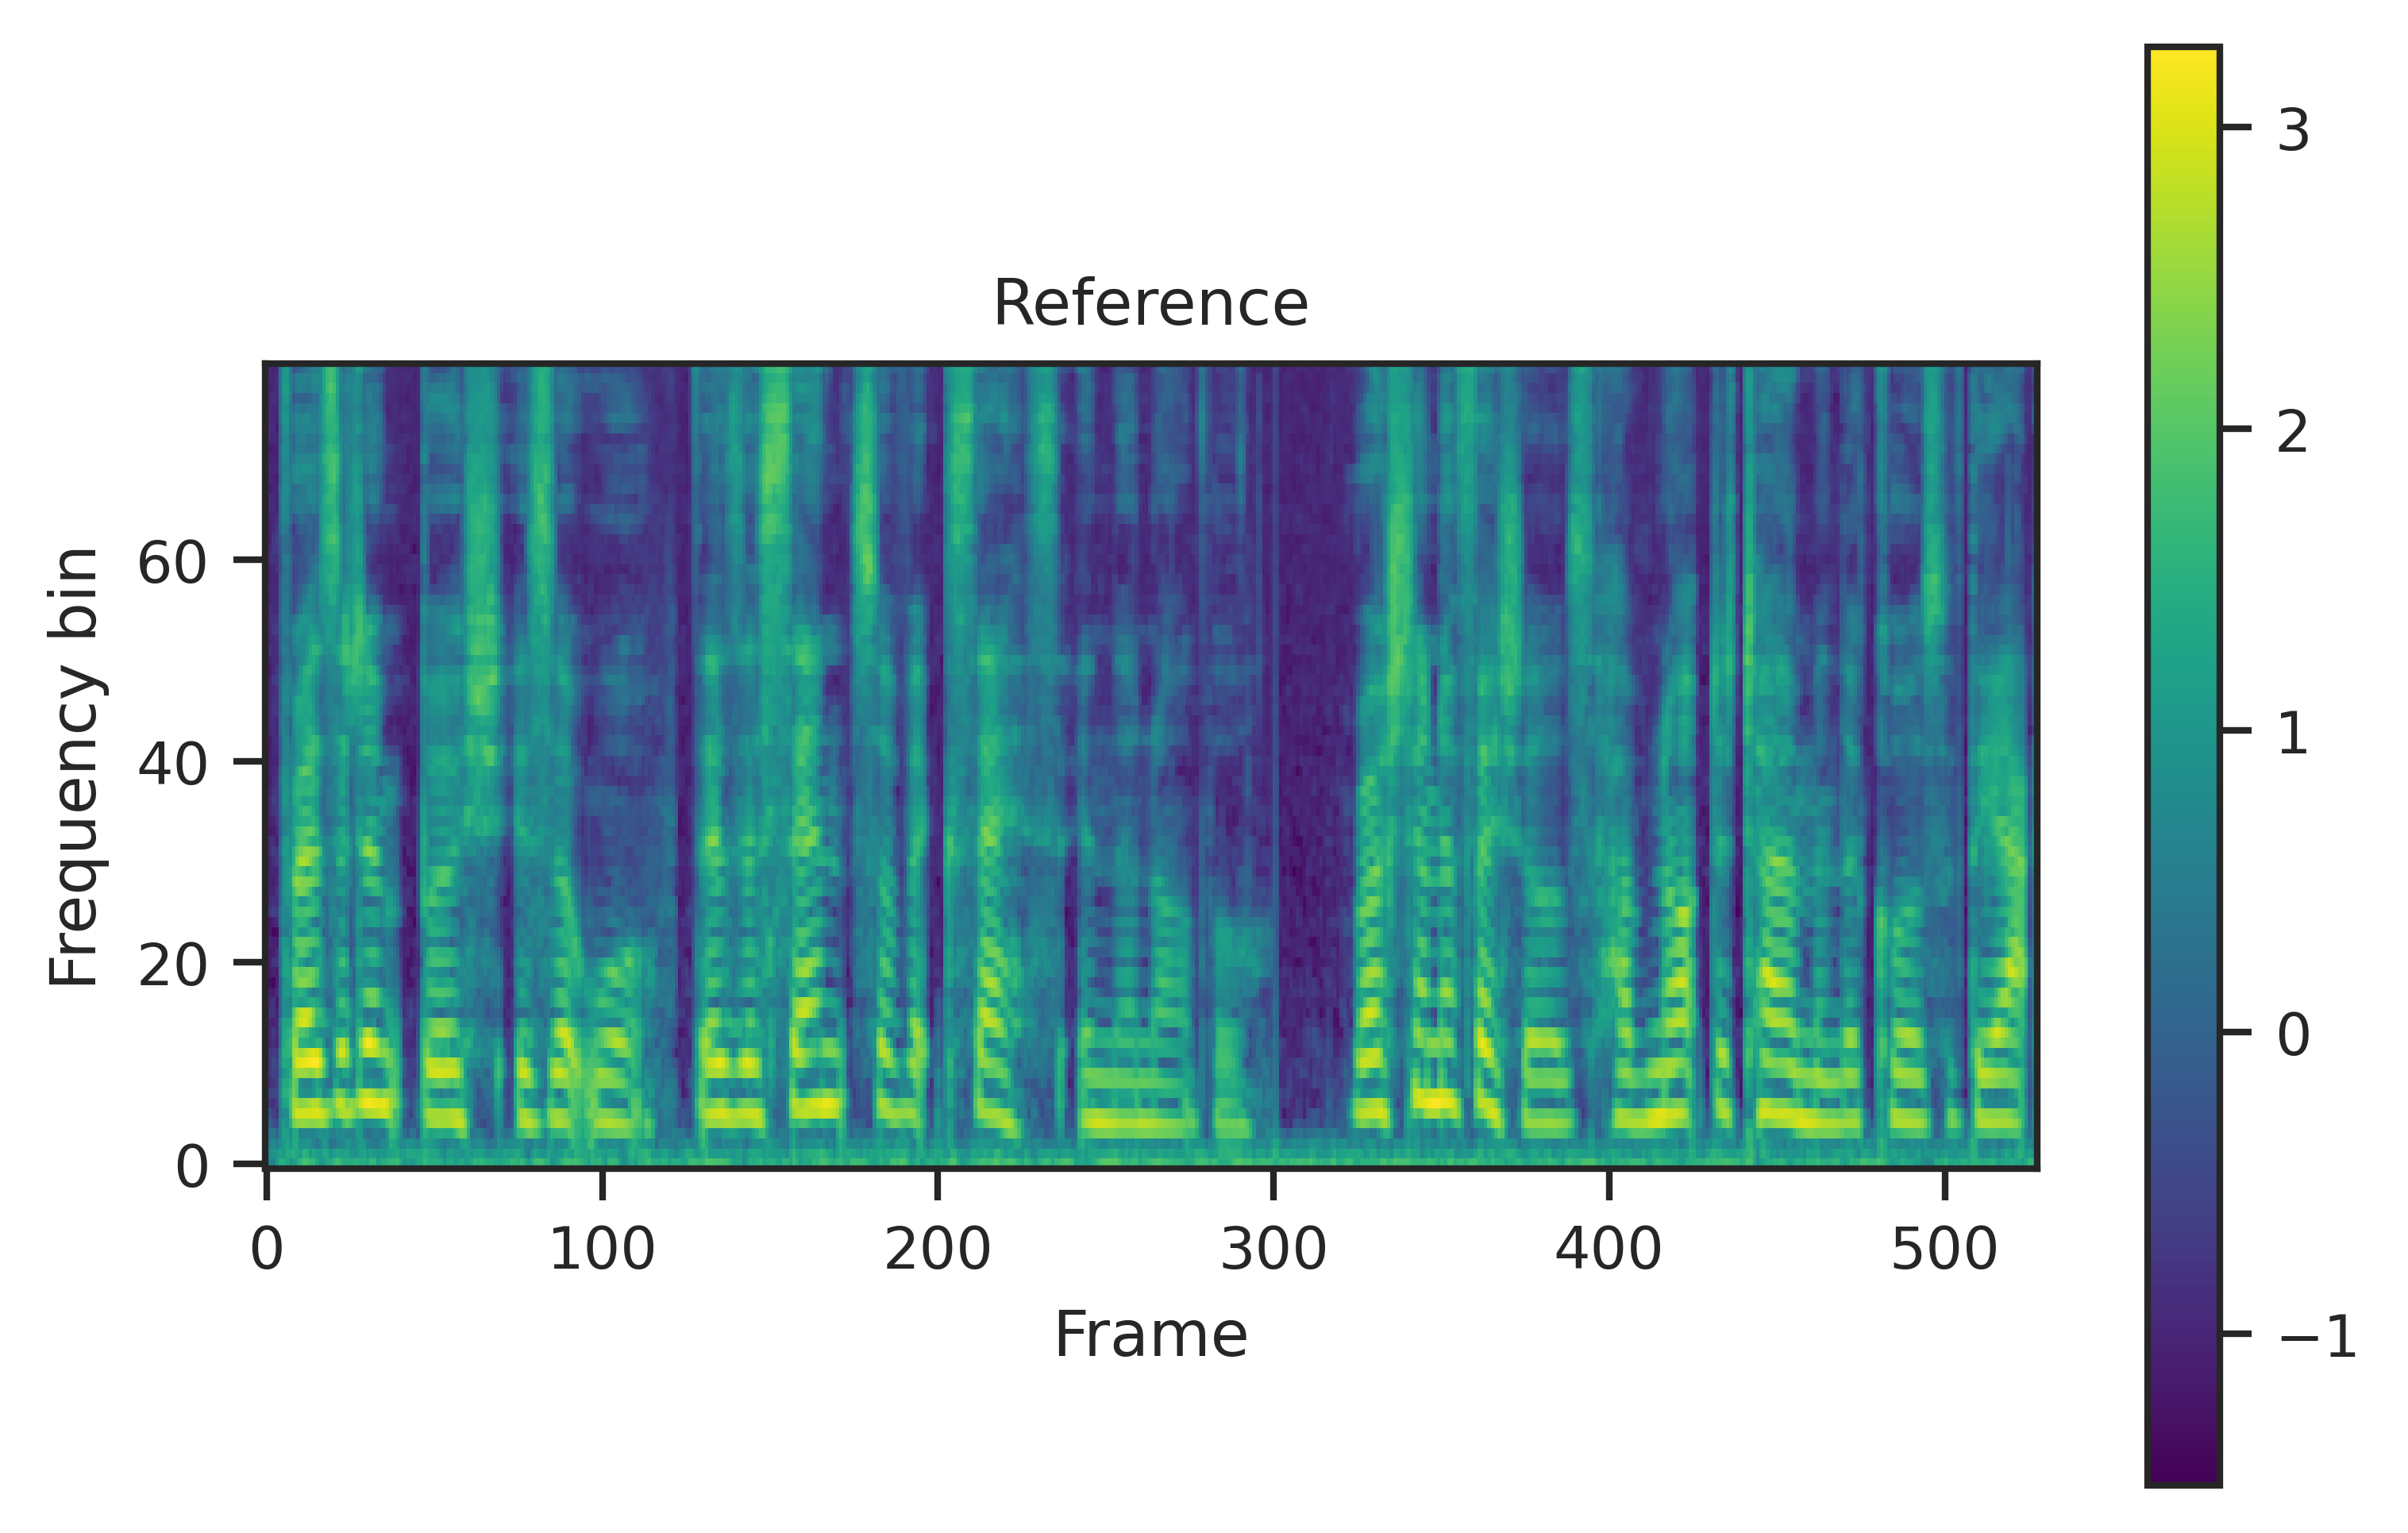

In [29]:
for title, path in paths:
    plot_spectrogram(preprocess(librosa.load(path, sr=24000)[0])[0], title = title, aspect = 3)

# 3. Train and validation loss
We have collected the train and validation loss of the runs through TensorBoard and placed them into the project folder. These results are visualized below. 

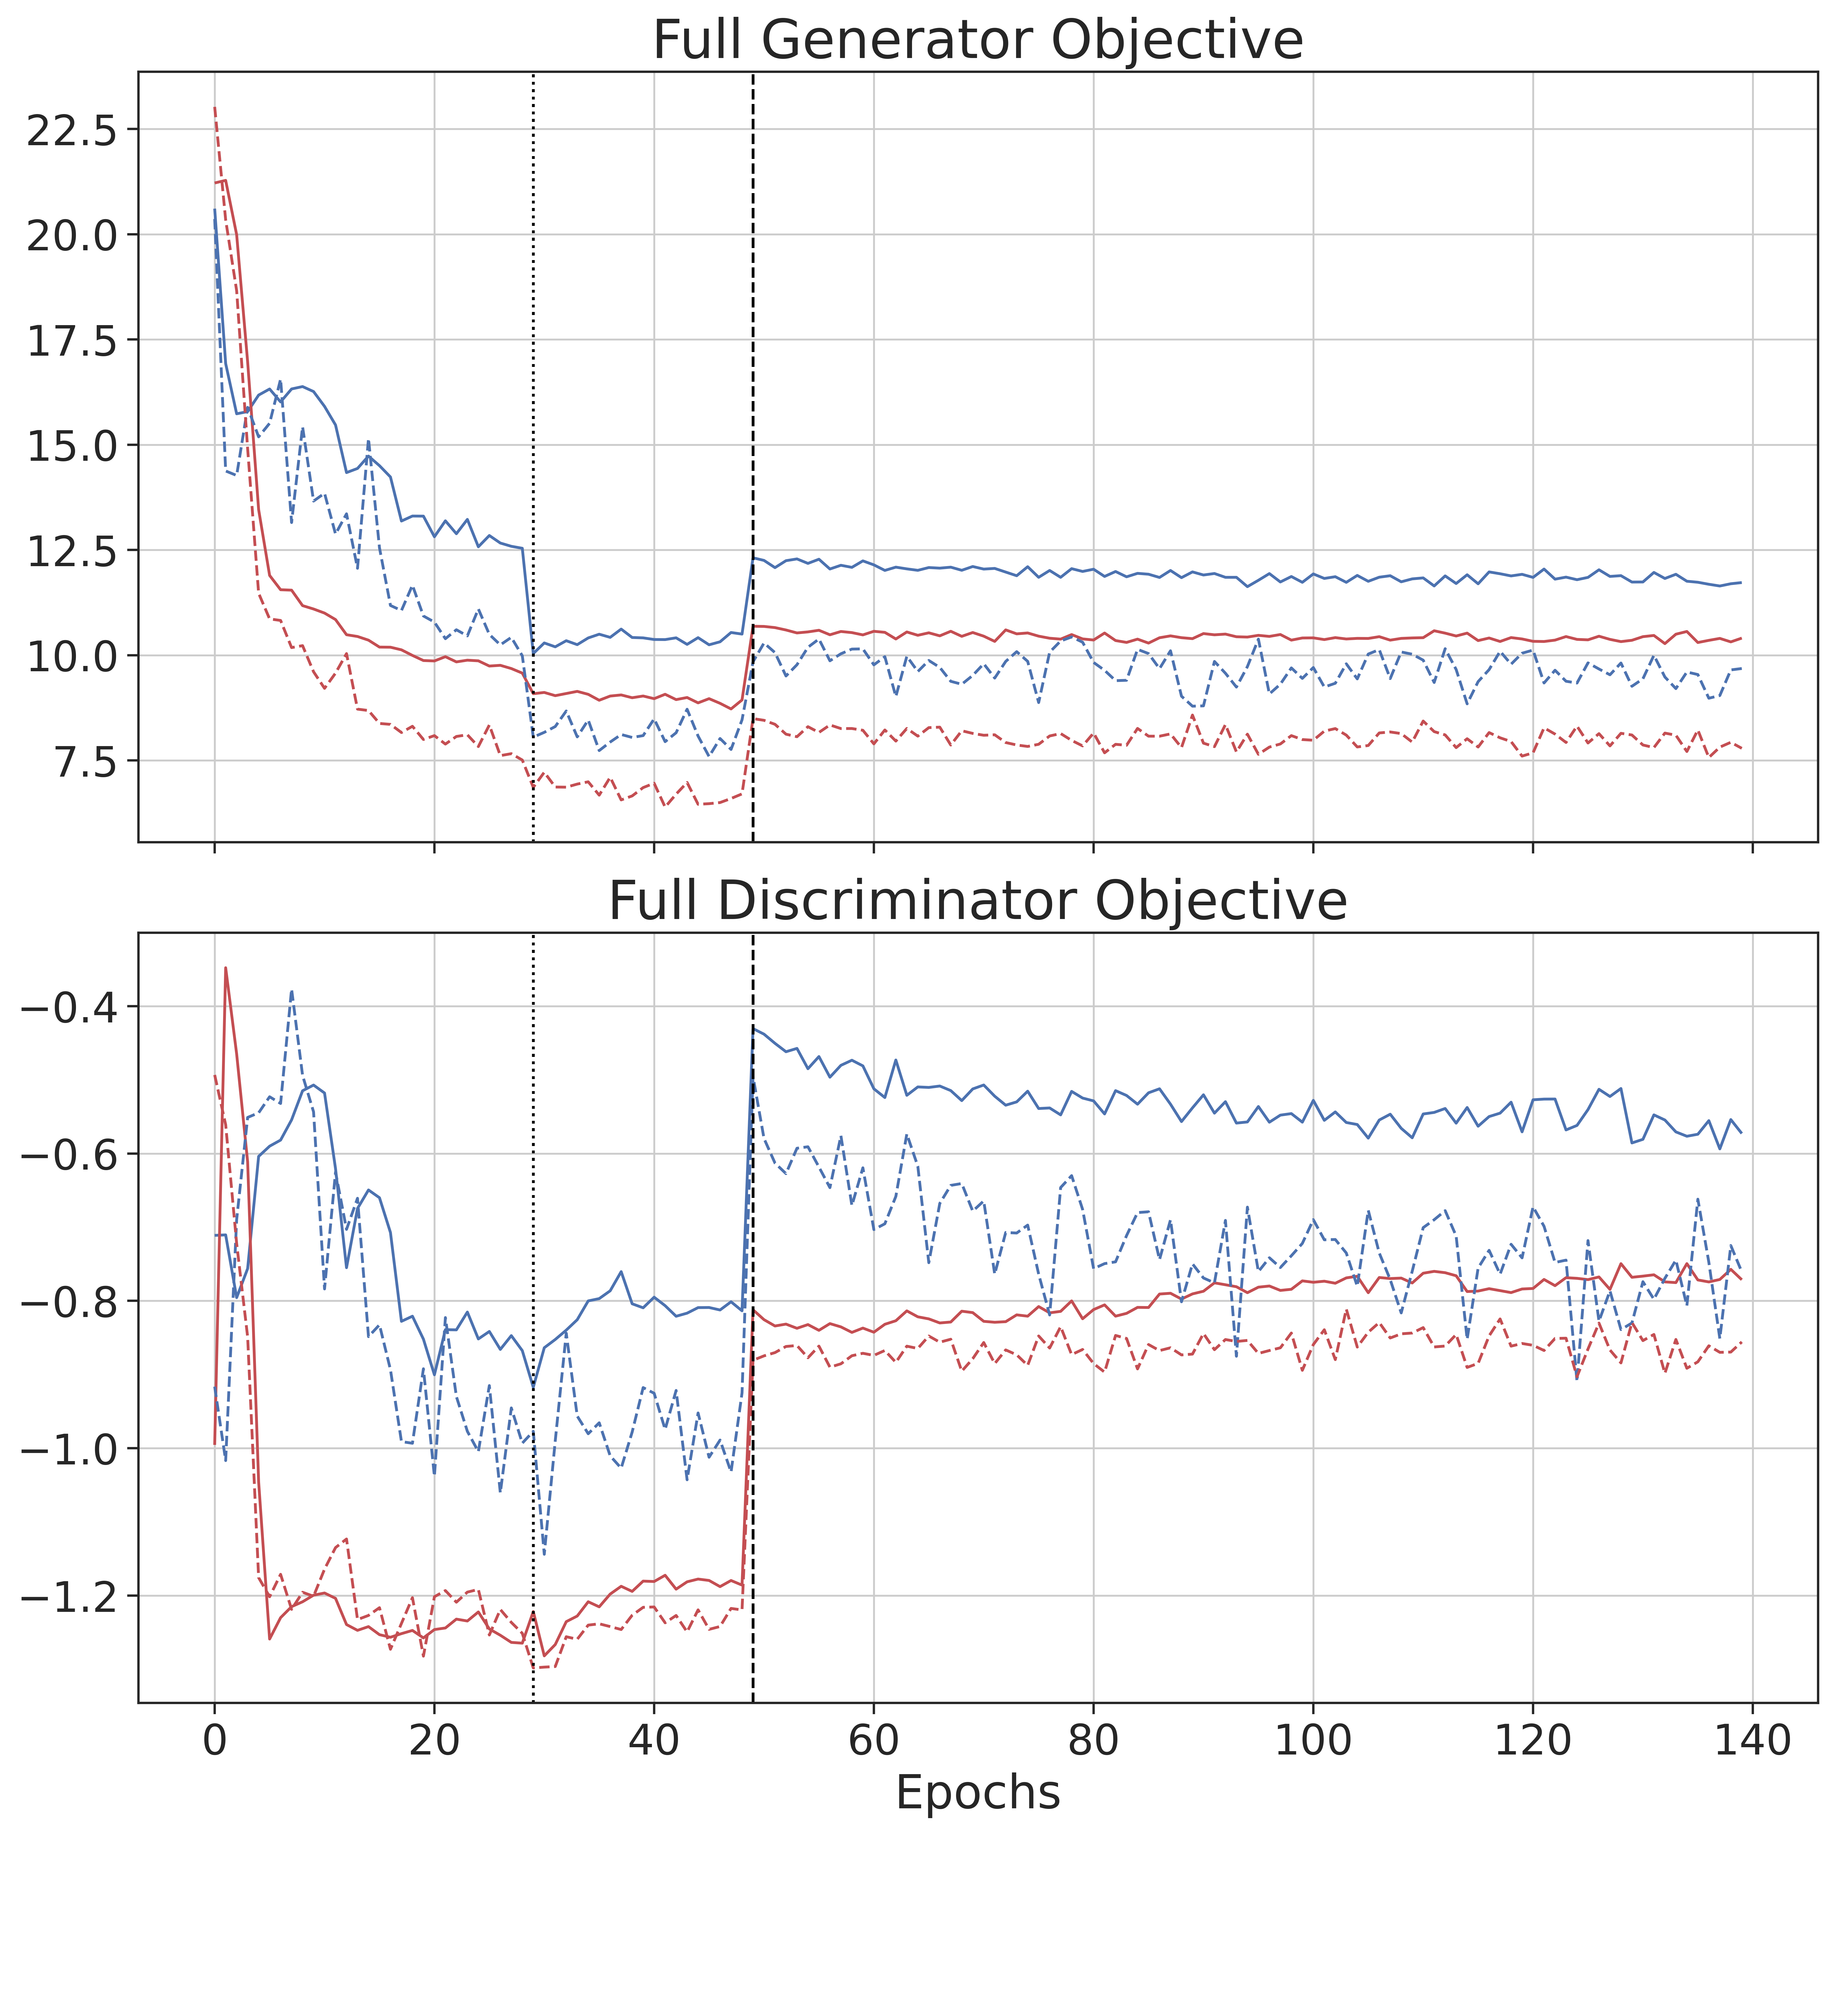

In [32]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

plt.close("all")
loss_types = ["sty", "cyc", "ds", "norm", "asr", "f0", "adv", "adv_cls", "real_adv_cls", "reg", "con_reg", "real", "fake", ]
loss_lambd = [1.0, 5.0, 1.0, 1.0, 10.0, 5.0, 2.0, 0.5, 0.1, 1.0, 10, 1.0, 1.0]
model_dfs = {}
for model in ["VanillaModel", "DWModel"]:
    dfs = {}
    for type in ["eval", "train"]:
        loss_df = []
        for j in range(len(loss_types)):
            temp = pd.read_csv(
                f"{path_to_project}/docs/loss/{model}/{type}/run-.-tag-{type}_"
                + loss_types[j]
                + ".csv",
                delimiter=",",
                )
            temp = temp.iloc[:140]
            temp = temp.drop(columns=["Wall time", "Step"])
            temp.columns = [loss_types[j]]
            temp[loss_types[j]] = temp[loss_types[j]] * loss_lambd[j]
            temp.reset_index()
            loss_df.append(temp)

        df = pd.concat(loss_df, axis=1, ignore_index=False)
        df["ds"] = df["ds"] * -1
        df["real"] = df["real"] * -1
        df["fake"] = df["fake"] * -1
        df["Full Generator Objective"] = df[
            ["sty", "cyc", "ds", "norm", "asr", "f0", "adv", "adv_cls"]
        ].sum(axis=1)
        df["Full Discriminator Objective"] = df[["real", "fake", "reg", "real_adv_cls", "con_reg"]].sum(axis=1)
                                        

        name_dict = {
            "sty": "Style reconstruction loss",  # 3
            "cyc": "Cycle consistency loss",  # 8
            "ds": "Style diversification loss",  # 4
            "norm": "Norm consistency loss",  # 7
            "asr": "Speech consistency loss",  # 6
            "f0": "F0 consistency loss",  # 5
            "adv": "Adversarial loss",  # 1
            "adv_cls": "Adversarial source classifier loss (Generator)",  # 2
            "real_adv_cls" : "Adversarial source classifier loss (Discriminator)",
            "reg" : "R1 regularizaition",
            "con_reg" : "Consistency regularization",
        }

        df = df.rename(columns=name_dict)
        dfs[type] = df
    model_dfs[model] = dfs
nrow = 2
ncol = 1
fig, axes = plt.subplots(nrow, ncol, figsize=(11, 11), sharex=True)


for type in ["train", "eval"]:
    for objective in ["Full Generator Objective","Full Discriminator Objective"]:
        for model in ["VanillaModel", "DWModel"]:
            if objective == "Full Generator Objective":
                if model == "VanillaModel":
                    if type == "train":
                        model_dfs[model][type][objective].plot(style='-', color='b', ax=axes[0])
                    else:
                        model_dfs[model][type][objective].plot(style='--', color='b', ax=axes[0])
                else: 
                    if type == "train":
                        model_dfs[model][type][objective].plot(style='-', color='r', ax=axes[0])
                    else:
                        model_dfs[model][type][objective].plot(style='--', color='r', ax=axes[0])
                axes[0].set_title(objective, fontdict={'fontsize': 23})
                axes[0].grid(True)
                axes[0].tick_params(axis='both', which='major', labelsize=18)
                axes[0].set_xlabel("Epochs", fontdict={'fontsize': 20})
                axes[0].axvline(29, c="black", linestyle=":")
                axes[0].axvline(49, c="black", linestyle="--")

            else:
                if model == "VanillaModel":
                    if type == "train":
                        model_dfs[model][type][objective].plot(style='-', color='b', ax=axes[1])
                    else:
                        model_dfs[model][type][objective].plot(style='--', color='b', ax=axes[1])
                else: 
                    if type == "train":
                        model_dfs[model][type][objective].plot(style='-', color='r', ax=axes[1])
                    else:
                        model_dfs[model][type][objective].plot(style='--', color='r', ax=axes[1])
                axes[1].set_title(objective, fontdict={'fontsize': 23})
                axes[1].grid(True)
                axes[1].tick_params(axis='both', which='major', labelsize=18)
                axes[1].set_xlabel("Epochs", fontdict={'fontsize': 20})
                axes[1].axvline(29, c="black", linestyle=":")
                axes[1].axvline(49, c="black", linestyle="--")

custom_lines = [
    Line2D([0], [0], linestyle='-', color='b', lw=4),
    Line2D([0], [0], linestyle='--', color='b', lw=4),
    Line2D([0], [0], linestyle='-', color='r', lw=4),
    Line2D([0], [0], linestyle='--', color='r', lw=4),
    Line2D([0], [0], linestyle=':', color='black', lw=4),
    Line2D([0], [0], linestyle='--', color='black', lw=4),
]
fig.legend(custom_lines, ["Train. original model", "Valid. original model","Train. reduced model", "Valid. reduced model", "Con. reg. intro.", "Adv. cls. intro."], prop={'size': 18}, ncol=3, bbox_to_anchor=(1, 0))
plt.tight_layout()
plt.savefig(f"{path_to_project}/docs/figures/losses.pdf", bbox_inches="tight", format='pdf')
plt.show()

